In [1]:
import pandas as pd
import keras
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 9,6

from keras.datasets import cifar10

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU

from keras import backend as K
from keras import applications
from keras import callbacks
from keras import optimizers
from keras.utils import np_utils
import random
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings(action='ignore')

2022-04-06 14:55:12.056257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 14:55:12.056278: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_model_history(history, title: str) -> None:
    """
    Plotting the learning curve of Keras model, broken down into loss curve and accuracy curve, 
    for both training and validation data.

    Args:
        history : Object returned by the .fit method of Keras model.
        title (str): Title of the plots.
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    fig.suptitle(title, size=15)
    plt.show()

# <span style='font-family:Georgia'> Data loading & preparation

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

BATCH_SIZE = 32
INPUT_SHAPE = X_train.shape[1:]
NUM_CLASSES=10

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [4]:
# Normalize input data
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Convert class labels to one-hot encoded
y_train = keras.utils.np_utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.np_utils.to_categorical(y_test, NUM_CLASSES)

# <span style='font-family:Georgia'> Fitting the Deep Learning Models

In [5]:
LR=1e-3 # chosen arbitrary, tuning performed later on for further experiments
EPOCHS=100  
PATIENCE=10
MIN_DELTA=0.01
early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

In [6]:
# Data augmentation - 2 different approaches

datagen1 = ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)
datagen1.fit(X_train)

datagen2 = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
datagen2.fit(X_train)

## <span style='font-family:Georgia'> Model concept no. 1

In [7]:
def generate_model1(learning_rate: float = LR):
    """
    Generate Keras Sequential model according to proposed architecture (1).

    Args:
        learning_rate (float, optional): Learning rate of the neural network. Defaults to LR.

    Returns:
        Keras Sequential model, complied, ready to use (to call .fit method).
    """

    model = Sequential()

    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding='same', input_shape=INPUT_SHAPE))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation("softmax"))
    
    model.compile(
        loss='categorical_crossentropy',  
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6), 
        metrics=['accuracy']
    )
    
    return model

In [8]:
model1 = generate_model1()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                        

2022-04-06 14:55:28.094963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-06 14:55:28.094988: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 14:55:28.095011: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: agatamakarewicz-Legion-Y540-15IRH
2022-04-06 14:55:28.095017: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: agatamakarewicz-Legion-Y540-15IRH
2022-04-06 14:55:28.095083: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-04-06 14:55:28.095118: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.54.0
2022-04-06 14:55:28.095733: I tensorflow/cor

In [9]:
model1_history = (
    model1.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test_ohe)
    )
)

Epoch 1/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.4119 - accuracy: 0.4894 - val_loss: 1.0278 - val_accuracy: 0.6337
Epoch 2/100
1563/1563 [==============================] - 45s 29ms/step - loss: 0.9839 - accuracy: 0.6538 - val_loss: 0.8255 - val_accuracy: 0.7113
Epoch 3/100
1563/1563 [==============================] - 46s 29ms/step - loss: 0.8409 - accuracy: 0.7057 - val_loss: 0.7501 - val_accuracy: 0.7397
Epoch 4/100
1563/1563 [==============================] - 48s 31ms/step - loss: 0.7606 - accuracy: 0.7333 - val_loss: 0.7255 - val_accuracy: 0.7438
Epoch 5/100
1563/1563 [==============================] - 44s 28ms/step - loss: 0.7022 - accuracy: 0.7538 - val_loss: 0.6943 - val_accuracy: 0.7605
Epoch 6/100
1563/1563 [==============================] - 46s 29ms/step - loss: 0.6619 - accuracy: 0.7684 - val_loss: 0.6617 - val_accuracy: 0.7681
Epoch 7/100
1563/1563 [==============================] - 44s 28ms/step - loss: 0.6207 - accuracy: 0.7808 - val_loss: 0

### <span style='font-family:Georgia'> Augmentation no. 1

In [10]:
model1_aug1 = generate_model1()
model1_aug1_history = (
    model1_aug1.fit(
        datagen1.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test_ohe),
        callbacks=[early_stop],
        workers=4,
        verbose=1
    )
) 

Epoch 1/100
1563/1563 [==============================] - 47s 29ms/step - loss: 1.7225 - accuracy: 0.3671 - val_loss: 1.3858 - val_accuracy: 0.5018
Epoch 2/100
1563/1563 [==============================] - 45s 29ms/step - loss: 1.4172 - accuracy: 0.4897 - val_loss: 1.1473 - val_accuracy: 0.5889
Epoch 3/100
1563/1563 [==============================] - 45s 29ms/step - loss: 1.2893 - accuracy: 0.5379 - val_loss: 1.0452 - val_accuracy: 0.6210
Epoch 4/100
1563/1563 [==============================] - 45s 29ms/step - loss: 1.2229 - accuracy: 0.5646 - val_loss: 0.9874 - val_accuracy: 0.6490
Epoch 5/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.1836 - accuracy: 0.5832 - val_loss: 0.9643 - val_accuracy: 0.6540
Epoch 6/100
1563/1563 [==============================] - 49s 31ms/step - loss: 1.1452 - accuracy: 0.5965 - val_loss: 1.0509 - val_accuracy: 0.6522
Epoch 7/100
1563/1563 [==============================] - 46s 29ms/step - loss: 1.1071 - accuracy: 0.6076 - val_loss: 0

### <span style='font-family:Georgia'> Augmentation no. 2

In [11]:
model1_aug2 = generate_model1()
model1_aug2_history = (
    model1_aug2.fit(
        datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test_ohe),
        callbacks=[early_stop],
        workers=4,
        verbose=1
    )
) 

Epoch 1/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.6798 - accuracy: 0.3750 - val_loss: 1.3564 - val_accuracy: 0.5019
Epoch 2/100
1563/1563 [==============================] - 46s 30ms/step - loss: 1.3772 - accuracy: 0.5000 - val_loss: 1.1604 - val_accuracy: 0.5786
Epoch 3/100
1563/1563 [==============================] - 46s 29ms/step - loss: 1.2600 - accuracy: 0.5446 - val_loss: 1.0372 - val_accuracy: 0.6287
Epoch 4/100
1563/1563 [==============================] - 46s 29ms/step - loss: 1.1800 - accuracy: 0.5784 - val_loss: 1.0511 - val_accuracy: 0.6290
Epoch 5/100
1563/1563 [==============================] - 46s 30ms/step - loss: 1.1342 - accuracy: 0.5949 - val_loss: 1.1154 - val_accuracy: 0.6130
Epoch 6/100
1563/1563 [==============================] - 46s 30ms/step - loss: 1.0941 - accuracy: 0.6093 - val_loss: 0.9903 - val_accuracy: 0.6554
Epoch 7/100
1563/1563 [==============================] - 46s 30ms/step - loss: 1.0635 - accuracy: 0.6216 - val_loss: 0

### <span style='font-family:Georgia'> Model no 1. results summary

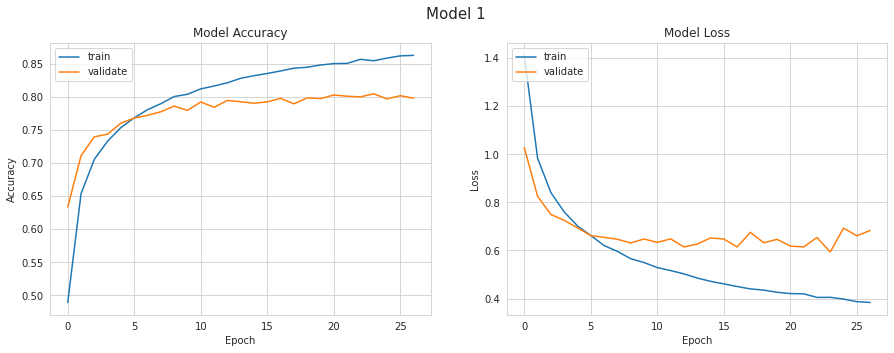

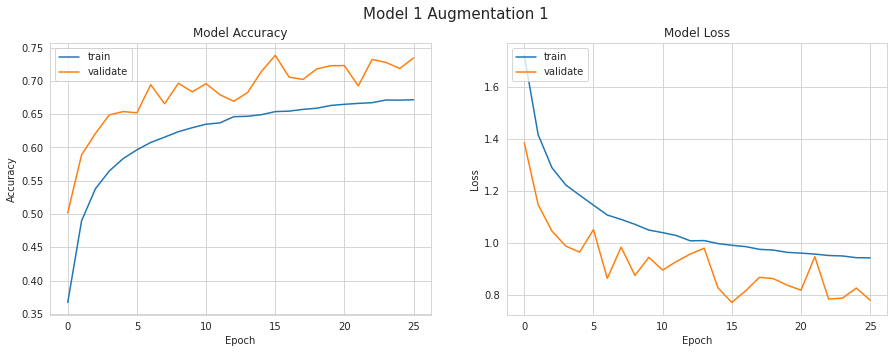

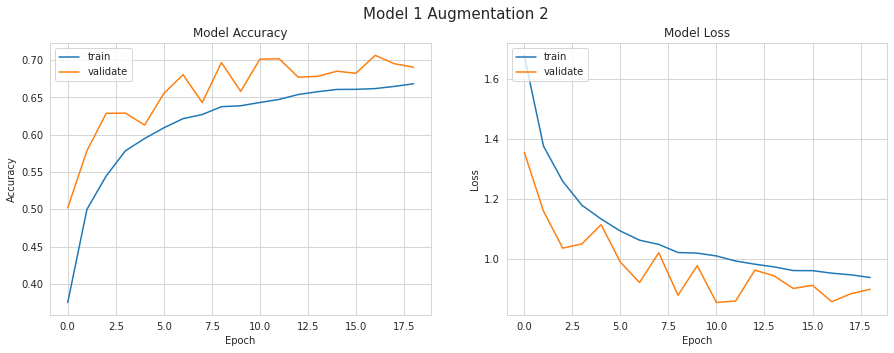

In [12]:
plot_model_history(model1_history, 'Model 1')
plot_model_history(model1_aug1_history, 'Model 1 Augmentation 1')
plot_model_history(model1_aug2_history, 'Model 1 Augmentation 2')

## <span style='font-family:Georgia'> Model concept no. 2

In [13]:
def generate_model2(learning_rate: float = LR):
    """
    Generate Keras Sequential model according to proposed architecture (2).

    Args:
        learning_rate (float, optional): Learning rate of the neural network. Defaults to LR.

    Returns:
        Keras Sequential model, complied, ready to use (to call .fit method).
    """

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6), 
              metrics=['accuracy'])
    
    return model    

In [14]:
model2 = generate_model2()
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [15]:
model2_history = (
    model2.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test_ohe)
    )
)

Epoch 1/100
1563/1563 [==============================] - 83s 52ms/step - loss: 1.7872 - accuracy: 0.3399 - val_loss: 1.4394 - val_accuracy: 0.4845
Epoch 2/100
1563/1563 [==============================] - 83s 53ms/step - loss: 1.3053 - accuracy: 0.5334 - val_loss: 1.0545 - val_accuracy: 0.6239
Epoch 3/100
1563/1563 [==============================] - 74s 47ms/step - loss: 1.0887 - accuracy: 0.6184 - val_loss: 0.9074 - val_accuracy: 0.6770
Epoch 4/100
1563/1563 [==============================] - 73s 47ms/step - loss: 0.9580 - accuracy: 0.6638 - val_loss: 0.8095 - val_accuracy: 0.7201
Epoch 5/100
1563/1563 [==============================] - 73s 47ms/step - loss: 0.8781 - accuracy: 0.6955 - val_loss: 0.8069 - val_accuracy: 0.7245
Epoch 6/100
1563/1563 [==============================] - 73s 47ms/step - loss: 0.8190 - accuracy: 0.7176 - val_loss: 0.6934 - val_accuracy: 0.7599
Epoch 7/100
1563/1563 [==============================] - 78s 50ms/step - loss: 0.7571 - accuracy: 0.7364 - val_loss: 0

### <span style='font-family:Georgia'> Augmentation no. 1

In [16]:
model2_aug1 = generate_model2()
model2_aug1_history = (
    model2_aug1.fit(
        datagen1.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test_ohe),
        callbacks=[early_stop],
        workers=4,
        verbose=1
    )
) 

Epoch 1/100
1563/1563 [==============================] - 80s 51ms/step - loss: 1.9506 - accuracy: 0.2716 - val_loss: 1.5493 - val_accuracy: 0.4191
Epoch 2/100
1563/1563 [==============================] - 80s 51ms/step - loss: 1.6866 - accuracy: 0.3781 - val_loss: 1.3657 - val_accuracy: 0.4893
Epoch 3/100
1563/1563 [==============================] - 87s 55ms/step - loss: 1.5307 - accuracy: 0.4424 - val_loss: 1.4805 - val_accuracy: 0.4903
Epoch 4/100
1563/1563 [==============================] - 88s 56ms/step - loss: 1.4210 - accuracy: 0.4915 - val_loss: 1.2736 - val_accuracy: 0.5712
Epoch 5/100
1563/1563 [==============================] - 80s 51ms/step - loss: 1.3362 - accuracy: 0.5255 - val_loss: 1.3193 - val_accuracy: 0.5428
Epoch 6/100
1563/1563 [==============================] - 80s 51ms/step - loss: 1.2557 - accuracy: 0.5583 - val_loss: 1.2715 - val_accuracy: 0.5772
Epoch 7/100
1563/1563 [==============================] - 76s 48ms/step - loss: 1.1967 - accuracy: 0.5778 - val_loss: 1

### <span style='font-family:Georgia'> Augmentation no. 2

In [17]:
model2_aug2 = generate_model2()
model2_aug2_history = (
    model2_aug2.fit( 
        datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test_ohe),
        callbacks=[early_stop],
        workers=4,
        verbose=1
    )
) 

Epoch 1/100
1563/1563 [==============================] - 77s 49ms/step - loss: 1.9084 - accuracy: 0.2689 - val_loss: 1.7924 - val_accuracy: 0.3274
Epoch 2/100
1563/1563 [==============================] - 76s 49ms/step - loss: 1.6275 - accuracy: 0.3938 - val_loss: 1.4500 - val_accuracy: 0.4561
Epoch 3/100
1563/1563 [==============================] - 76s 48ms/step - loss: 1.4862 - accuracy: 0.4548 - val_loss: 1.3312 - val_accuracy: 0.5217
Epoch 4/100
1563/1563 [==============================] - 76s 48ms/step - loss: 1.3646 - accuracy: 0.5080 - val_loss: 1.2172 - val_accuracy: 0.5718
Epoch 5/100
1563/1563 [==============================] - 76s 49ms/step - loss: 1.2706 - accuracy: 0.5425 - val_loss: 1.2981 - val_accuracy: 0.5486
Epoch 6/100
1563/1563 [==============================] - 87s 56ms/step - loss: 1.1934 - accuracy: 0.5720 - val_loss: 1.1208 - val_accuracy: 0.5960
Epoch 7/100
1563/1563 [==============================] - 77s 49ms/step - loss: 1.1435 - accuracy: 0.5918 - val_loss: 1

### <span style='font-family:Georgia'> Model no 2. results summary

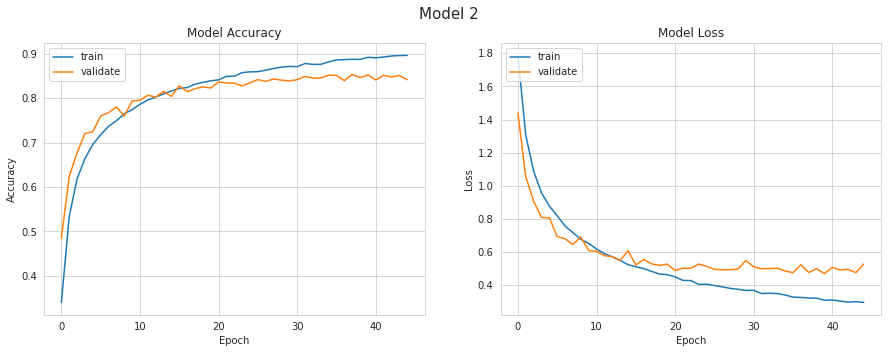

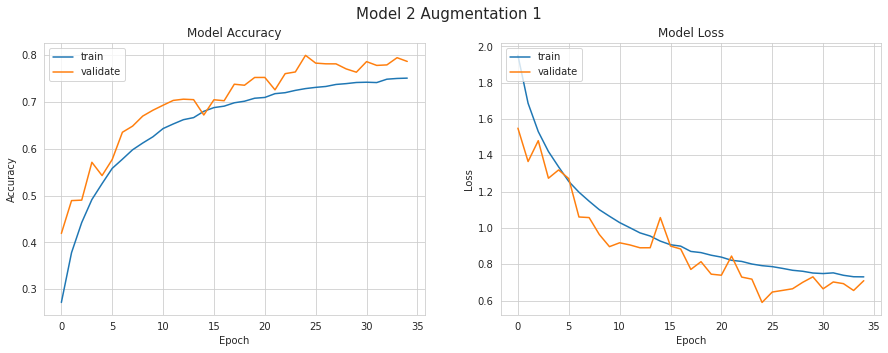

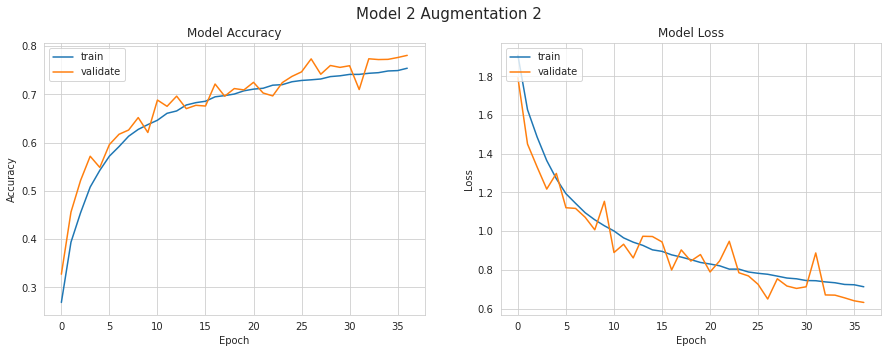

In [19]:
plot_model_history(model2_history, title='Model 2')
plot_model_history(model2_aug1_history, title='Model 2 Augmentation 1')
plot_model_history(model2_aug2_history, title='Model 2 Augmentation 2')

## <span style='font-family:Georgia'> Model concept no. 3

In [20]:
def generate_model3(learning_rate: float = LR):
    """
    Generate Keras Sequential model according to proposed architecture (3).

    Args:
        learning_rate (float, optional): Learning rate of the neural network. Defaults to LR.

    Returns:
        Keras Sequential model, complied, ready to use (to call .fit method).
    """

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=INPUT_SHAPE, activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6), 
               metrics=['accuracy'])
    
    return model

In [21]:
model3 = generate_model3()
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 11, 11, 32)        16416     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 800)               0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [22]:
model3_history = (
    model3.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stop],
        shuffle=True,
        verbose=1,
        validation_data=(X_test, y_test_ohe)
    )
)

Epoch 1/100
1563/1563 [==============================] - 17s 10ms/step - loss: 1.7895 - accuracy: 0.3361 - val_loss: 1.5480 - val_accuracy: 0.4285
Epoch 2/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.4607 - accuracy: 0.4739 - val_loss: 1.2848 - val_accuracy: 0.5386
Epoch 3/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.3446 - accuracy: 0.5247 - val_loss: 1.2404 - val_accuracy: 0.5532
Epoch 4/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.2532 - accuracy: 0.5615 - val_loss: 1.1925 - val_accuracy: 0.5763
Epoch 5/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1922 - accuracy: 0.5852 - val_loss: 1.1138 - val_accuracy: 0.6063
Epoch 6/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1438 - accuracy: 0.6037 - val_loss: 1.1297 - val_accuracy: 0.6017
Epoch 7/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0921 - accuracy: 0.6240 - val_loss: 1

### <span style='font-family:Georgia'> Augmentation no. 1

In [23]:
model3_aug1 = generate_model3()
model3_aug1_history = (
    model3_aug1.fit(
        datagen1.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test_ohe),
        callbacks=[early_stop],
        workers=4,
        verbose=1
    )
)

Epoch 1/100
1563/1563 [==============================] - 34s 21ms/step - loss: 1.9761 - accuracy: 0.2562 - val_loss: 1.6870 - val_accuracy: 0.3787
Epoch 2/100
1563/1563 [==============================] - 32s 20ms/step - loss: 1.7570 - accuracy: 0.3501 - val_loss: 1.5186 - val_accuracy: 0.4422
Epoch 3/100
1563/1563 [==============================] - 32s 20ms/step - loss: 1.6831 - accuracy: 0.3843 - val_loss: 1.4539 - val_accuracy: 0.4598
Epoch 4/100
1563/1563 [==============================] - 33s 21ms/step - loss: 1.6297 - accuracy: 0.4098 - val_loss: 1.3735 - val_accuracy: 0.5015
Epoch 5/100
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5858 - accuracy: 0.4268 - val_loss: 1.4744 - val_accuracy: 0.4648
Epoch 6/100
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5660 - accuracy: 0.4346 - val_loss: 1.3483 - val_accuracy: 0.5110
Epoch 7/100
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5381 - accuracy: 0.4464 - val_loss: 1

### <span style='font-family:Georgia'> Augmentation no. 2

In [24]:
model3_aug2 = generate_model3()
model3_aug2_history = (
    model3_aug2.fit(
        datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test_ohe),
        callbacks=[early_stop],
        workers=4,
        verbose=1
    )
) 

Epoch 1/100
1563/1563 [==============================] - 33s 21ms/step - loss: 1.9440 - accuracy: 0.2624 - val_loss: 1.6121 - val_accuracy: 0.4062
Epoch 2/100
1563/1563 [==============================] - 32s 21ms/step - loss: 1.6913 - accuracy: 0.3783 - val_loss: 1.5491 - val_accuracy: 0.4231
Epoch 3/100
1563/1563 [==============================] - 32s 21ms/step - loss: 1.6109 - accuracy: 0.4101 - val_loss: 1.5652 - val_accuracy: 0.4334
Epoch 4/100
1563/1563 [==============================] - 32s 21ms/step - loss: 1.5648 - accuracy: 0.4305 - val_loss: 1.4101 - val_accuracy: 0.4799
Epoch 5/100
1563/1563 [==============================] - 32s 21ms/step - loss: 1.5182 - accuracy: 0.4518 - val_loss: 1.3962 - val_accuracy: 0.4966
Epoch 6/100
1563/1563 [==============================] - 32s 21ms/step - loss: 1.4872 - accuracy: 0.4619 - val_loss: 1.3407 - val_accuracy: 0.5118
Epoch 7/100
1563/1563 [==============================] - 32s 21ms/step - loss: 1.4639 - accuracy: 0.4769 - val_loss: 1

### <span style='font-family:Georgia'> Model no. 3 results summary

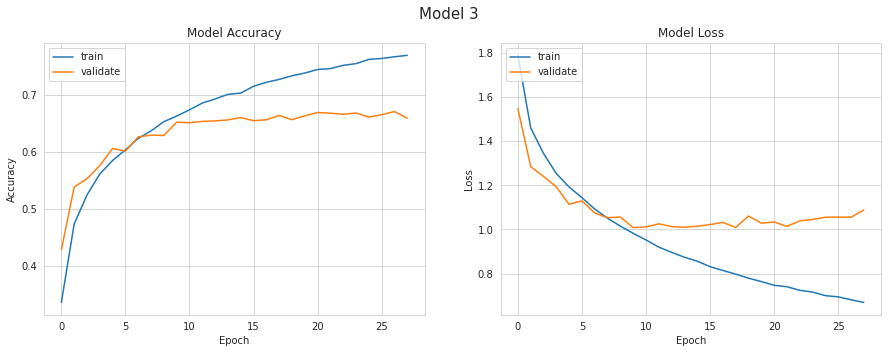

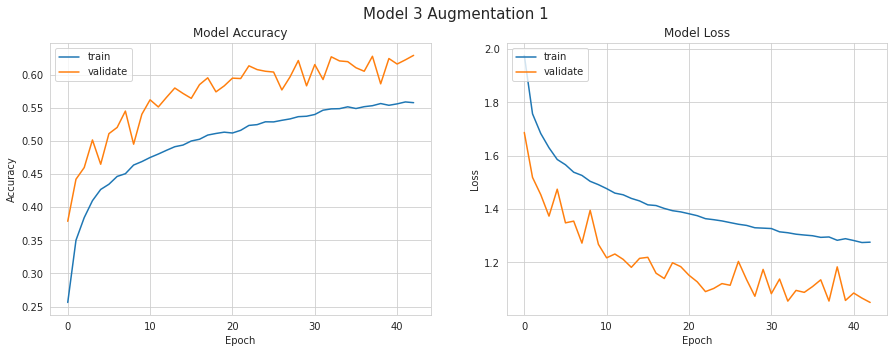

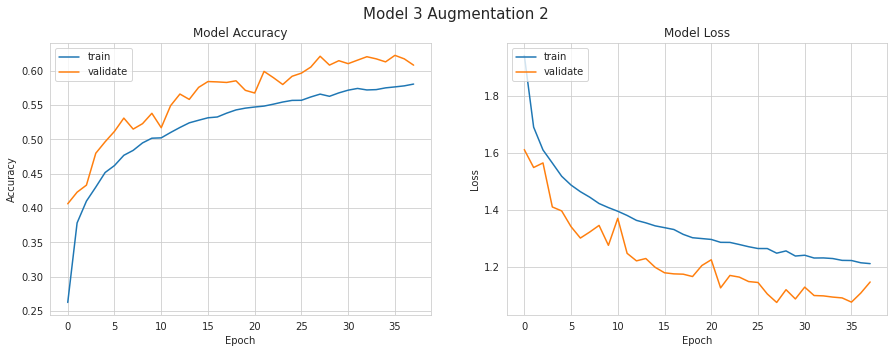

In [25]:
plot_model_history(model3_history, 'Model 3')
plot_model_history(model3_aug1_history, 'Model 3 Augmentation 1')
plot_model_history(model3_aug2_history, 'Model 3 Augmentation 2')

# <span style='font-family:Georgia'> Tuning hyperparameters (learning rate)

In [26]:
learning_rate = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
EPOCHS = 50
acc_all = []
model1_history_all = []
model2_history_all = []
model3_history_all = []
for lr in learning_rate:
    print(lr)
    model1_lr = generate_model1(learning_rate=lr)
    model2_lr = generate_model2(learning_rate=lr)
    model3_lr = generate_model3(learning_rate=lr)
    model1_history_lr = model1_lr.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop],
                                shuffle=True, verbose=1, validation_data=(X_test, y_test_ohe))
    model2_history_lr = model2_lr.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop],
                                shuffle=True, verbose=1, validation_data=(X_test, y_test_ohe))
    model3_history_lr = model3_lr.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop],
                                shuffle=True, verbose=1, validation_data=(X_test, y_test_ohe))
    model1_history_all.append(model1_history_lr)
    model2_history_all.append(model2_history_lr)
    model3_history_all.append(model3_history_lr)

    y_pred_1 = model1_lr.predict(X_test)
    y_pred_2 = model2_lr.predict(X_test)
    y_pred_3 = model3_lr.predict(X_test)
    y_pred_classes_1 = np.argmax(y_pred_1, axis=-1)
    y_pred_classes_2 = np.argmax(y_pred_2, axis=-1)
    y_pred_classes_3 = np.argmax(y_pred_3, axis=-1)
    acc_lr = [accuracy_score(y_test, y_pred_classes_1),
              accuracy_score(y_test, y_pred_classes_2),
              accuracy_score(y_test, y_pred_classes_3)]
    acc_all.append(acc_lr)
models_history = [model1_history_all, model2_history_all, model3_history_all]

0.01
Epoch 1/50
1563/1563 [==============================] - 43s 27ms/step - loss: 12.9384 - accuracy: 0.1772 - val_loss: 2.0312 - val_accuracy: 0.2694
Epoch 2/50
1563/1563 [==============================] - 42s 27ms/step - loss: 2298.1321 - accuracy: 0.2311 - val_loss: 50325.1055 - val_accuracy: 0.1000
Epoch 3/50
1563/1563 [==============================] - 42s 27ms/step - loss: 18064.5547 - accuracy: 0.1379 - val_loss: 691.1926 - val_accuracy: 0.1671
Epoch 4/50
1563/1563 [==============================] - 42s 27ms/step - loss: 771.8177 - accuracy: 0.1468 - val_loss: 123.2157 - val_accuracy: 0.1803
Epoch 5/50
1563/1563 [==============================] - 46s 29ms/step - loss: 177.6163 - accuracy: 0.1478 - val_loss: 37.1619 - val_accuracy: 0.1856
Epoch 6/50
1563/1563 [==============================] - 46s 30ms/step - loss: 69.5352 - accuracy: 0.1544 - val_loss: 14.8272 - val_accuracy: 0.2082
Epoch 7/50
1563/1563 [==============================] - 46s 29ms/step - loss: 32.5846 - accuracy

Epoch 13/50
1563/1563 [==============================] - 73s 47ms/step - loss: 0.5801 - accuracy: 0.7978 - val_loss: 0.5654 - val_accuracy: 0.8096
Epoch 14/50
1563/1563 [==============================] - 73s 47ms/step - loss: 0.5569 - accuracy: 0.8048 - val_loss: 0.6048 - val_accuracy: 0.7972
Epoch 15/50
1563/1563 [==============================] - 73s 47ms/step - loss: 0.5396 - accuracy: 0.8142 - val_loss: 0.5268 - val_accuracy: 0.8239
Epoch 16/50
1563/1563 [==============================] - 73s 47ms/step - loss: 0.5241 - accuracy: 0.8181 - val_loss: 0.5363 - val_accuracy: 0.8232
Epoch 17/50
1563/1563 [==============================] - 73s 47ms/step - loss: 0.5017 - accuracy: 0.8274 - val_loss: 0.5704 - val_accuracy: 0.8158
Epoch 18/50
1563/1563 [==============================] - 73s 47ms/step - loss: 0.4856 - accuracy: 0.8318 - val_loss: 0.5207 - val_accuracy: 0.8284
Epoch 19/50
1563/1563 [==============================] - 73s 47ms/step - loss: 0.4744 - accuracy: 0.8362 - val_loss: 0

Epoch 9/50
1563/1563 [==============================] - 44s 28ms/step - loss: 0.9810 - accuracy: 0.6544 - val_loss: 0.9292 - val_accuracy: 0.6761
Epoch 10/50
1563/1563 [==============================] - 44s 28ms/step - loss: 0.9449 - accuracy: 0.6679 - val_loss: 0.8950 - val_accuracy: 0.6898
Epoch 11/50
1563/1563 [==============================] - 47s 30ms/step - loss: 0.9138 - accuracy: 0.6794 - val_loss: 0.8739 - val_accuracy: 0.6966
Epoch 12/50
1563/1563 [==============================] - 47s 30ms/step - loss: 0.8905 - accuracy: 0.6890 - val_loss: 0.8580 - val_accuracy: 0.7024
Epoch 13/50
1563/1563 [==============================] - 47s 30ms/step - loss: 0.8626 - accuracy: 0.6963 - val_loss: 0.8375 - val_accuracy: 0.7090
Epoch 14/50
1563/1563 [==============================] - 47s 30ms/step - loss: 0.8396 - accuracy: 0.7050 - val_loss: 0.8178 - val_accuracy: 0.7166
Epoch 15/50
1563/1563 [==============================] - 47s 30ms/step - loss: 0.8170 - accuracy: 0.7119 - val_loss: 0.

Epoch 21/50
1563/1563 [==============================] - 82s 52ms/step - loss: 0.6353 - accuracy: 0.7761 - val_loss: 0.6498 - val_accuracy: 0.7737
Epoch 22/50
1563/1563 [==============================] - 82s 52ms/step - loss: 0.6217 - accuracy: 0.7816 - val_loss: 0.6301 - val_accuracy: 0.7811
Epoch 23/50
1563/1563 [==============================] - 82s 52ms/step - loss: 0.6049 - accuracy: 0.7874 - val_loss: 0.6520 - val_accuracy: 0.7768
Epoch 24/50
1563/1563 [==============================] - 82s 52ms/step - loss: 0.5870 - accuracy: 0.7940 - val_loss: 0.6210 - val_accuracy: 0.7897
Epoch 25/50
1563/1563 [==============================] - 82s 52ms/step - loss: 0.5740 - accuracy: 0.7968 - val_loss: 0.6043 - val_accuracy: 0.7932
Epoch 26/50
1563/1563 [==============================] - 81s 52ms/step - loss: 0.5620 - accuracy: 0.8021 - val_loss: 0.6249 - val_accuracy: 0.7891
Epoch 27/50
1563/1563 [==============================] - 82s 52ms/step - loss: 0.5486 - accuracy: 0.8063 - val_loss: 0

Epoch 38/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8255 - accuracy: 0.7186 - val_loss: 0.9093 - val_accuracy: 0.6912
Epoch 39/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8144 - accuracy: 0.7226 - val_loss: 0.9206 - val_accuracy: 0.6868
Epoch 40/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8005 - accuracy: 0.7279 - val_loss: 0.9099 - val_accuracy: 0.6904
Epoch 41/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8002 - accuracy: 0.7295 - val_loss: 0.9553 - val_accuracy: 0.6731
Epoch 42/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.7893 - accuracy: 0.7297 - val_loss: 0.9361 - val_accuracy: 0.6847
Epoch 43/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.7771 - accuracy: 0.7376 - val_loss: 0.9358 - val_accuracy: 0.6861
Epoch 44/50
1563/1563 [==============================] - 16s 11ms/step - loss: 0.7719 - accuracy: 0.7374 - val_loss: 0

Epoch 46/50
1563/1563 [==============================] - 47s 30ms/step - loss: 1.1559 - accuracy: 0.5901 - val_loss: 1.0895 - val_accuracy: 0.6163
Epoch 47/50
1563/1563 [==============================] - 47s 30ms/step - loss: 1.1476 - accuracy: 0.5923 - val_loss: 1.0848 - val_accuracy: 0.6184
Epoch 48/50
1563/1563 [==============================] - 48s 30ms/step - loss: 1.1445 - accuracy: 0.5952 - val_loss: 1.0788 - val_accuracy: 0.6189
Epoch 49/50
1563/1563 [==============================] - 48s 30ms/step - loss: 1.1421 - accuracy: 0.5976 - val_loss: 1.0825 - val_accuracy: 0.6198
Epoch 50/50
1563/1563 [==============================] - 47s 30ms/step - loss: 1.1351 - accuracy: 0.5977 - val_loss: 1.0759 - val_accuracy: 0.6218
Epoch 1/50
1563/1563 [==============================] - 84s 54ms/step - loss: 2.7522 - accuracy: 0.1301 - val_loss: 2.4663 - val_accuracy: 0.1051
Epoch 2/50
1563/1563 [==============================] - 84s 54ms/step - loss: 2.3121 - accuracy: 0.1648 - val_loss: 2.4

Epoch 2/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.2132 - accuracy: 0.1932 - val_loss: 2.1286 - val_accuracy: 0.2535
Epoch 3/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.1356 - accuracy: 0.2169 - val_loss: 2.0414 - val_accuracy: 0.2908
Epoch 4/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.0774 - accuracy: 0.2385 - val_loss: 1.9676 - val_accuracy: 0.3093
Epoch 5/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.0273 - accuracy: 0.2574 - val_loss: 1.9141 - val_accuracy: 0.3275
Epoch 6/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.9839 - accuracy: 0.2703 - val_loss: 1.8688 - val_accuracy: 0.3341
Epoch 7/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.9490 - accuracy: 0.2819 - val_loss: 1.8282 - val_accuracy: 0.3502
Epoch 8/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.9193 - accuracy: 0.2898 - val_loss: 1.7976 -

Epoch 8/50
1563/1563 [==============================] - 44s 28ms/step - loss: 2.1764 - accuracy: 0.2092 - val_loss: 2.1558 - val_accuracy: 0.2675
Epoch 9/50
1563/1563 [==============================] - 43s 28ms/step - loss: 2.1407 - accuracy: 0.2185 - val_loss: 2.1177 - val_accuracy: 0.2692
Epoch 10/50
1563/1563 [==============================] - 44s 28ms/step - loss: 2.1138 - accuracy: 0.2255 - val_loss: 2.0864 - val_accuracy: 0.2750
Epoch 11/50
1563/1563 [==============================] - 43s 28ms/step - loss: 2.0885 - accuracy: 0.2325 - val_loss: 2.0603 - val_accuracy: 0.2809
Epoch 12/50
1563/1563 [==============================] - 43s 28ms/step - loss: 2.0689 - accuracy: 0.2402 - val_loss: 2.0385 - val_accuracy: 0.2864
Epoch 13/50
1563/1563 [==============================] - 43s 28ms/step - loss: 2.0521 - accuracy: 0.2463 - val_loss: 2.0210 - val_accuracy: 0.2934
Epoch 14/50
1563/1563 [==============================] - 43s 28ms/step - loss: 2.0390 - accuracy: 0.2499 - val_loss: 2.0

Epoch 3/50
1563/1563 [==============================] - 15s 9ms/step - loss: 2.2977 - accuracy: 0.1075 - val_loss: 2.2930 - val_accuracy: 0.1262
Epoch 4/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.2937 - accuracy: 0.1157 - val_loss: 2.2873 - val_accuracy: 0.1317
Epoch 5/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.2887 - accuracy: 0.1211 - val_loss: 2.2800 - val_accuracy: 0.1359
Epoch 6/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.2821 - accuracy: 0.1291 - val_loss: 2.2715 - val_accuracy: 0.1465
Epoch 7/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.2748 - accuracy: 0.1358 - val_loss: 2.2622 - val_accuracy: 0.1526
Epoch 8/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.2671 - accuracy: 0.1425 - val_loss: 2.2524 - val_accuracy: 0.1571
Epoch 9/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.2592 - accuracy: 0.1462 - val_loss: 2.2422 - 

In [27]:
results_acc = pd.DataFrame(acc_all)
results_acc.columns = ['1', '2', '3']
results_acc.index = learning_rate
results_acc.index.name = "Learning rate"
results_acc_melted = pd.melt(results_acc.reset_index(), id_vars=['Learning rate'], value_vars=['1', '2', '3'])
results_acc_melted.columns=['Learning rate', 'Model', 'Accuracy']
results_acc.reset_index(inplace=True)

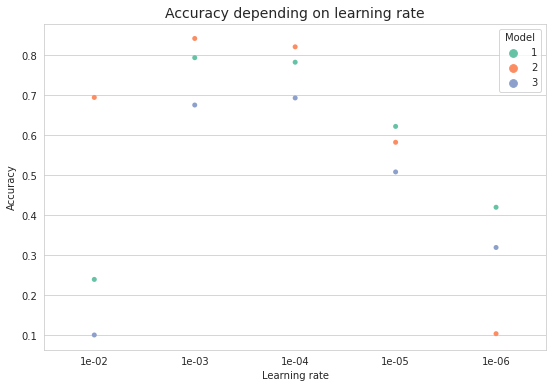

In [28]:
# accuracy
for j in range(results_acc_melted.shape[0]):
    results_acc_melted.loc[j, 'Learning rate'] = '{:.0e}'.format(results_acc_melted.loc[j, 'Learning rate'])
sns.stripplot(x="Learning rate", y="Accuracy", hue="Model",
               data=results_acc_melted, palette="Set2", dodge=False, jitter=0.0)    
plt.title("Accuracy depending on learning rate", size=14);

In [30]:
# results for the best learning rate for each model
best_lr_results = []
lr_best_index = 1
lr_best_3_index = 2
for i in range(3):
    if i==2: lr_index = lr_best_3_index 
    else: lr_index=lr_best_index
    train_acc = models_history[i][lr_index].history['accuracy'][-1]
    test_acc = models_history[i][lr_index].history['val_accuracy'][-1]
    train_loss = models_history[i][lr_index].history['loss'][-1]
    test_loss = models_history[i][lr_index].history['val_loss'][-1]
    model_stats = [train_acc, test_acc, train_loss, test_loss]
    best_lr_results.append(model_stats)
pd.DataFrame(best_lr_results, columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss'], index=['Model 1', 'Model 2', 'Model 3'])

,train_accuracy,test_accuracy,train_loss,test_loss
Model 1,0.86160,0.7937,0.390343,0.688905
Model 2,0.87506,0.8418,0.351098,0.504412
Model 3,0.75052,0.6930,0.737433,0.905251


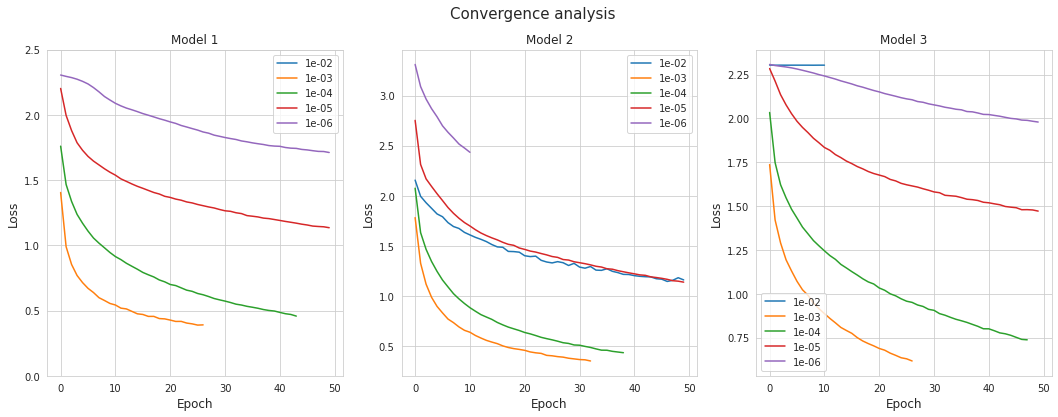

In [34]:
# convergence
fig, axes = plt.subplots(1,3,figsize=(18,6))
models = ['1', '2', '3']
for i in range(3):
    model_name=models[i]
    history = models_history[i]
    for j, history_lr in enumerate(history):
        data_lr = history_lr.history['loss']
        sns.lineplot(data=data_lr, ax=axes[i], label='{:.0e}'.format(learning_rate[j]))
        if i == 0 : axes[i].set_ylim([0,2.5]) # due to huge loss values for 1e-2 (to make other lines visible)
        axes[i].set_title('Model '+model_name)
        axes[i].set_xlabel('Epoch', size=12)
        axes[i].set_ylabel('Loss', size=12)
fig.suptitle("Convergence analysis", size=15)
plt.show()

# <span style='font-family:Georgia'> Models Evaluation

In [47]:
def plot_heatmaps(models_results: list, title: str) -> None:
    """
    Plot heatmaps based on the confusion matrices of a given model (basic version and with 2 different augmentations).)

    Args:
        models_results (list): List of confusion matrices of the evaluated models.
        title (str): Title of the plots.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    models = ['Basic', 'Augmentation 1', 'Augmentation 2']
    for i in range(3):
        sns.heatmap(models_results[i], annot=True, cmap="Blues", ax=axes[i], fmt='d', annot_kws={"size": 12})
        axes[i].set_title(models[i], size=15)
        axes[i].set_xticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        axes[i].set_yticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=12)

    fig.suptitle(title, size=18)
    plt.tight_layout()
    plt.show()

## <span style='font-family:Georgia'> Model concept no. 1

In [35]:
y_pred_test_1 = model1.predict(X_test)
y_pred_test_classes_1 = np.argmax(y_pred_test_1, axis=-1)

y_pred_test_1_aug1 = model1_aug1.predict(X_test)
y_pred_test_classes_1_aug1 = np.argmax(y_pred_test_1_aug1, axis=-1)

y_pred_test_1_aug2 = model1_aug2.predict(X_test)
y_pred_test_classes_1_aug2 = np.argmax(y_pred_test_1_aug2, axis=-1)

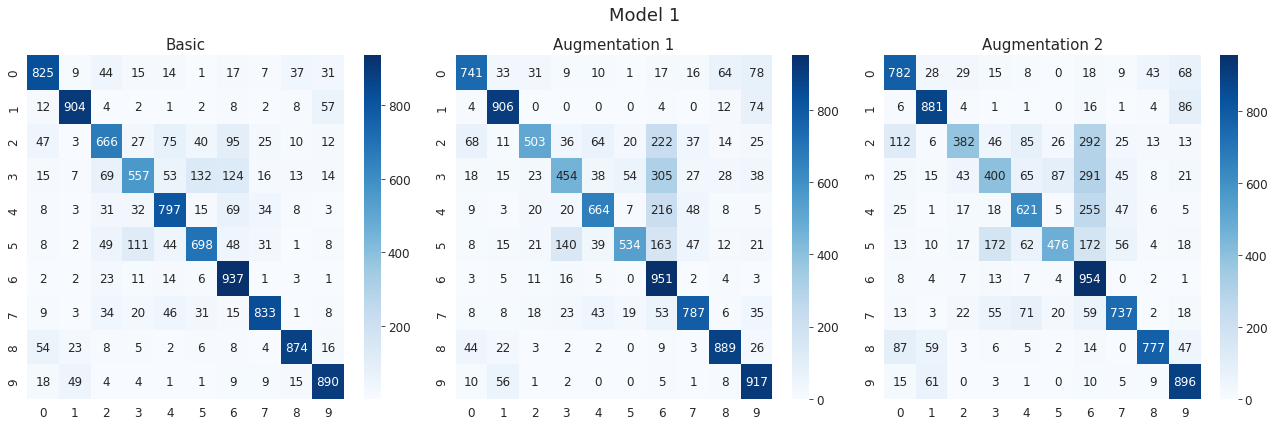

In [48]:
models_results = [pd.DataFrame(confusion_matrix(y_test, y_pred_test_classes_1)),
                  pd.DataFrame(confusion_matrix(y_test, y_pred_test_classes_1_aug1)),
                  pd.DataFrame(confusion_matrix(y_test, y_pred_test_classes_1_aug2))]
plot_heatmaps(models_results, 'Model 1')

In [46]:
print(classification_report(y_test, y_pred_test_classes_1))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1000
           1       0.90      0.90      0.90      1000
           2       0.71      0.67      0.69      1000
           3       0.71      0.56      0.62      1000
           4       0.76      0.80      0.78      1000
           5       0.75      0.70      0.72      1000
           6       0.70      0.94      0.80      1000
           7       0.87      0.83      0.85      1000
           8       0.90      0.87      0.89      1000
           9       0.86      0.89      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



## <span style='font-family:Georgia'> Model concept no. 2

In [49]:
y_pred_test_2 = model2.predict(X_test)
y_pred_test_classes_2 = np.argmax(y_pred_test_2, axis=-1)

y_pred_test_2_aug1 = model2_aug1.predict(X_test)
y_pred_test_classes_2_aug1 = np.argmax(y_pred_test_2_aug1, axis=-1)

y_pred_test_2_aug2 = model2_aug2.predict(X_test)
y_pred_test_classes_2_aug2 = np.argmax(y_pred_test_2_aug2, axis=-1)

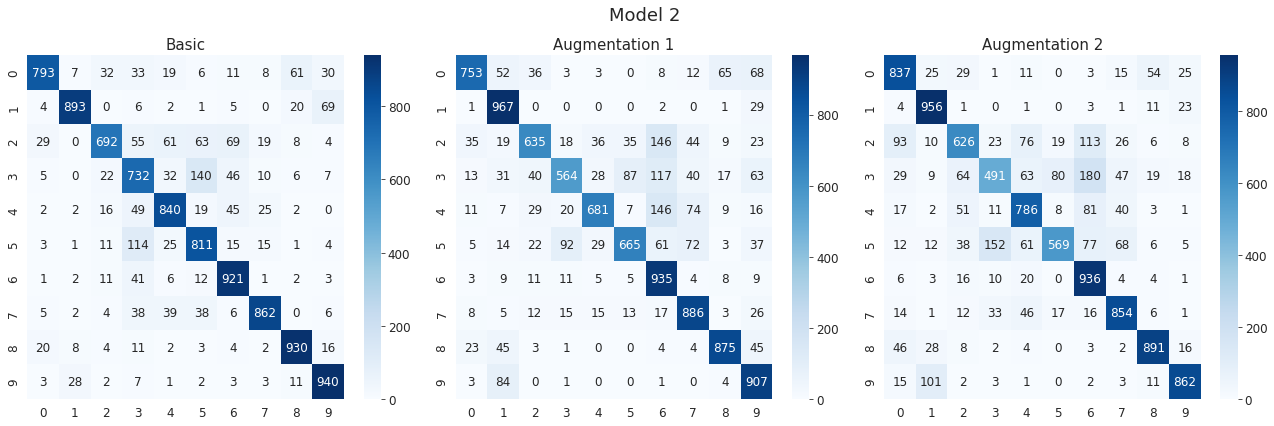

In [50]:
models_results = [pd.DataFrame(confusion_matrix(y_test, y_pred_test_classes_2)),
                  pd.DataFrame(confusion_matrix(y_test, y_pred_test_classes_2_aug1)),
                  pd.DataFrame(confusion_matrix(y_test, y_pred_test_classes_2_aug2))]
plot_heatmaps(models_results, 'Model 2')

In [51]:
print(classification_report(y_test, y_pred_test_classes_2))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1000
           1       0.95      0.89      0.92      1000
           2       0.87      0.69      0.77      1000
           3       0.67      0.73      0.70      1000
           4       0.82      0.84      0.83      1000
           5       0.74      0.81      0.77      1000
           6       0.82      0.92      0.87      1000
           7       0.91      0.86      0.89      1000
           8       0.89      0.93      0.91      1000
           9       0.87      0.94      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



## <span style='font-family:Georgia'> Model concept no. 3

In [52]:
y_pred_test_3 = model3.predict(X_test)
y_pred_test_classes_3 = np.argmax(y_pred_test_3, axis=-1)

y_pred_test_3_aug1 = model3_aug1.predict(X_test)
y_pred_test_classes_3_aug1 = np.argmax(y_pred_test_3_aug1, axis=-1)

y_pred_test_3_aug2 = model3_aug2.predict(X_test)
y_pred_test_classes_3_aug2 = np.argmax(y_pred_test_3_aug2, axis=-1)

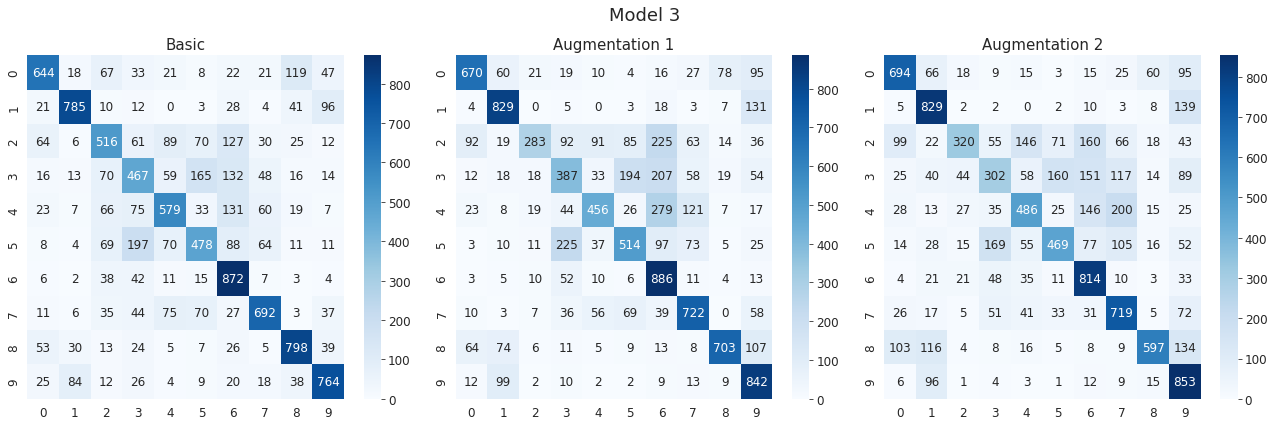

In [54]:
models_results = [pd.DataFrame(confusion_matrix(y_test, y_pred_test_classes_3)),
                  pd.DataFrame(confusion_matrix(y_test, y_pred_test_classes_3_aug1)),
                  pd.DataFrame(confusion_matrix(y_test, y_pred_test_classes_3_aug2))]
plot_heatmaps(models_results, 'Model 3')

In [55]:
print(classification_report(y_test, y_pred_test_classes_3))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1000
           1       0.82      0.79      0.80      1000
           2       0.58      0.52      0.54      1000
           3       0.48      0.47      0.47      1000
           4       0.63      0.58      0.61      1000
           5       0.56      0.48      0.51      1000
           6       0.59      0.87      0.71      1000
           7       0.73      0.69      0.71      1000
           8       0.74      0.80      0.77      1000
           9       0.74      0.76      0.75      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000

